In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import vaemof
from vaemof import experiments
from vaemof import utils
from vaemof.vocabs import SELFIESVocab, MOFVocab, PropVocab
from vaemof import modules
from vaemof import training
from vaemof.model import VAEMOF
from vaemof import configs

from vaemof.utils import header_str
vaemof.experiments.plot_settings()

RDKit WARNING: [00:07:21] Enabling RDKit 2019.09.3 jupyter extensions
/home/beangoben/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
import os
import random
from tqdm.auto import tqdm
import numpy as np
import torch
import rdkit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from itertools import product
from collections import OrderedDict

print(f'rdkit : {rdkit.__version__}')
print(f'torch : {torch.__version__}')
print(f'cuda? {torch.cuda.is_available()}')
tqdm.pandas()
utils.disable_rdkit_log()

rdkit : 2019.09.3
torch : 1.4.0
cuda? True


## Hparams and model

In [6]:
WORK_DIR = 'results/best/'
hparams_file = os.path.join(WORK_DIR,'config.json')
hparams = configs.AttributeDict.from_jsonfile(hparams_file)
hparams['train_device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
utils.set_seed(hparams['train_seed'])
device = torch.device(hparams['train_device'])
configs.print_config(hparams)
model = VAEMOF.load(hparams)

==================================== config ====================================
== train == :
        train_device:                cuda
          train_seed:                  42
    train_batch_size:                1536
        train_epochs:                  60
            train_lr:   0.000131385712092
     train_clip_grad:                  20
== vae == :
      vae_latent_dim:                 256
           vae_y_dec:                True
     vae_selfies_dec:                True
         vae_mof_enc:                True
         vae_mof_dec:                True
vae_duplicate_smiles:                True
== mof == :
        mof_encoding:                 all
   mof_weighted_loss:               False
         mof_w_start:                 0.0
           mof_w_end:                 0.5
           mof_start:                  15
    mof_const_length:                  10
== y == :
            y_labels:['lcd', 'pld', 'density', 'avf', 'avsa', 'agsa', 'co2n2_co2_mol_kg', 'co2n2_n2_mol_kg', 'co2n2

## Load MOF data

Assemble smiles formula: [organic core][metal_node][topology][branch_smiles]

In [7]:
smiles_column = 'branch_smiles'
testtrain_column = 'train/test'
df = experiments.get_generator_df(csv_file=hparams['files_data'],
                                  smiles_column=smiles_column,
                                  use_duplicates=hparams['vae_duplicate_smiles'],
                                  testing=testing)
ids2mofs, mof2ids, mof_columns = experiments.get_mofdict(
    df, hparams['mof_encoding'])
df.head()

=================================== Real run ===================================
df shape: (2049964, 8)
df columns: ['branch_smiles', 'id2mof', 'metal_node', 'mof_index', 'organic_core', 'randomized', 'topology', 'train/test']
Found 713 unique mofs


branch_smiles  id2mof  metal_node  \
0  CC(c1cc(O)cc(O)c1)(C(Sc1cc(O)cc(O)c1)c1cc(O)cc...       0  sym_7_mc_4   
1  Oc1ccc(-c2cc(/C=C/c3c(-c4ccc(O)cc4)cc([Lr])c(-...       0  sym_7_mc_4   
2  O=S(=O)(O)Cc1nn([Lr])c(CS(=O)(=O)O)c1-c1c(CS(=...       0  sym_7_mc_4   
3  [Lr]c1ccc(-c2c(-c3ccccc3)cc([Lr])c(-c3ccccc3)c...       0  sym_7_mc_4   
4  [Lr]c1ccc(N2C=C(c3ccncc3)N(c3c(-c4ccncc4)cc([L...       0  sym_7_mc_4   

   mof_index organic_core  randomized topology  train/test  
0        4.0         None       False      acs           1  
1       10.0         None       False      acs           1  
2       18.0         None       False      acs           1  
3       23.0         None       False      acs           1  
4       29.0         None       False      acs           1

## Load property data

In [8]:
prop_df = experiments.get_prop_df(csv_file=hparams['files_prop'],
                                  targets=hparams['y_labels'],
                                  mof2ids=mof2ids,
                                  testing=testing,
                                  smiles_column=smiles_column,
                                  compute_scscore=True)
prop_df.head()

=================================== Real run ===================================
Restored variables from data/scscore_1024uint8_model.ckpt-10654.as_numpy.json.gz



Removed 2923 datapoints due to mask.
Removed 1819 datapoints due non-valid mof (mof2ids).
Removed 245 datapoints due to high selectivity.


organic_core  metal_node topology  \
0         None  sym_7_mc_4      acs   
1         None  sym_7_mc_4      acs   
2         None  sym_7_mc_4      acs   
3         None  sym_7_mc_4      acs   
4         None  sym_7_mc_4      acs   

                                       branch_smiles       lcd       pld  \
0  COc1c(/C=C/c2ccc([Lr])cc2)cc(OC)c(/C=C/c3ccc([...  24.87798  19.29733   
1         CSC1=C2CCC(=C(C(=C2SC)[Lr])SC)C(=C1[Lr])SC   7.78281   5.18969   
2   O=C(c1cc(O)c(cc1O)[Lr])OOC(=O)c1cc(O)c(cc1O)[Lr]  17.01677  15.91720   
3   Oc1c(cc(c(c1O)[Lr])O)c1nnc(nn1)c1ccc(c(c1)O)[Lr]  19.50569  17.17410   
4                        [Lr]C12C=CC(C=C1)(C=C2)[Lr]   9.58653   8.21739   

    density      avf      avsa      agsa  ...  co2ch4_selectivity  \
0  0.164554  0.75459  1159.130  7044.060  ...            1.786937   
1  1.119280  0.07631   978.891   874.575  ...            3.197185   
2  0.320703  0.61736  1628.620  5078.290  ...            3.004385   
3  0.291374  0.66206  1401.740  4810.800  ...            2.250807   
4  0.799733  0.24196  2020.860  2526.910  ...            2.167731   

   co2ch4_heat_avg  co2ch4_heat_co2  co2ch4_heat_ch4  co2ch4_heat_molfrac  \
0         -8.58733        -12.08169         -7.92879             -8.61737   
1        -20.54264        -24.18495        -18.74239            -20.17205   
2        -11.22187        -16.39748         -9.43473            -11.17660   
3         -9.49245        -13.39225         -8.37161             -9.37550   
4        -15.36924        -18.34929        -14.67475            -15.38911   

   selfies_safe  mask  train/test   scscore  id2mof  
0          True  True           1  3.384814       0  
1          True  True           0  3.176298       0  
2          True  True           1  2.668208       0  
3          True  True           1  3.688210       0  
4          True  True           1  1.831772       0  

[5 rows x 29 columns]

## Train/test splits and hparams

In [9]:
test_index = np.array(df[df[testtrain_column] == 0].index.tolist())
prop_test_index = np.array(
    prop_df[prop_df[testtrain_column] == 0].index.tolist())
test_mof = model.df_to_tuples(df.loc[test_index], smiles_column)
prop_test = model.df_to_tuples(prop_df.loc[prop_test_index], smiles_column)
print(len(test_mof), len(prop_test))
print(f'Test  sizes: {len(test_index):7d} and {len(prop_test_index):7d}')


154997 4107
Test  sizes:  154997 and    4107


## Training stats

In [11]:
log_df = pd.read_csv(configs.at_results_dir(hparams,'files_log'))
print(log_df.shape)
print(log_df.columns)
log_df.head()

(60, 69)
Index(['epoch', 'test_kl', 'test_x', 'test_mof', 'test_y', 'test_loss',
       'lcd-r2', 'lcd-MAE', 'pld-r2', 'pld-MAE', 'density-r2', 'density-MAE',
       'avf-r2', 'avf-MAE', 'avsa-r2', 'avsa-MAE', 'agsa-r2', 'agsa-MAE',
       'co2n2_co2_mol_kg-r2', 'co2n2_co2_mol_kg-MAE', 'co2n2_n2_mol_kg-r2',
       'co2n2_n2_mol_kg-MAE', 'co2n2_selectivity-r2', 'co2n2_selectivity-MAE',
       'co2n2_heat_avg-r2', 'co2n2_heat_avg-MAE', 'co2n2_heat_co2-r2',
       'co2n2_heat_co2-MAE', 'co2n2_heat_n2-r2', 'co2n2_heat_n2-MAE',
       'co2n2_heat_molfrac-r2', 'co2n2_heat_molfrac-MAE',
       'co2ch4_co2_mol_kg-r2', 'co2ch4_co2_mol_kg-MAE', 'co2ch4_ch4_mol_kg-r2',
       'co2ch4_ch4_mol_kg-MAE', 'co2ch4_selectivity-r2',
       'co2ch4_selectivity-MAE', 'co2ch4_heat_avg-r2', 'co2ch4_heat_avg-MAE',
       'co2ch4_heat_co2-r2', 'co2ch4_heat_co2-MAE', 'co2ch4_heat_ch4-r2',
       'co2ch4_heat_ch4-MAE', 'co2ch4_heat_molfrac-r2',
       'co2ch4_heat_molfrac-MAE', 'scscore-r2', 'scscore-MAE', 'lr',

epoch      test_kl    test_x   test_mof    test_y  test_loss    lcd-r2  \
0      0  1653.554132  1.364864  18.345172  1.977622   1.381399  0.885473   
1      1   617.763148  0.968894  17.493920  1.330961   1.027733  0.818016   
2      2   403.205128  0.792128  17.308871  1.178287   0.864902  0.868510   
3      3   294.568250  0.680266  17.222104  1.133569   0.758543  0.871705   
4      4   227.035605  0.598566  17.178173  1.130119   0.678251  0.890727   

      lcd-MAE    pld-r2     pld-MAE  ...   mof_acc   mean_r2  train_kl_ratio  \
0  106.713158  0.333587  210.026245  ...  0.980805 -0.608966        0.007062   
1  147.890900  0.164152  209.521118  ...  1.117194 -0.850204        0.057015   
2  132.862411  0.297248  186.852509  ...  1.256411 -0.442091        0.080217   
3  134.665817  0.308299  180.270157  ...  1.383843 -0.392474        0.097626   
4  124.071220  0.492294  162.748505  ...  1.381486 -0.099692        0.110606   

   train_x_ratio  train_mof_ratio  train_y_ratio  test_kl_ratio  test_x_ratio  \
0       0.992938              0.0            0.0       0.011970      0.988030   
1       0.942985              0.0            0.0       0.057251      0.942749   
2       0.919783              0.0            0.0       0.084142      0.915858   
3       0.902374              0.0            0.0       0.103194      0.896806   
4       0.889394              0.0            0.0       0.117486      0.882514   

   test_mof_ratio  test_y_ratio  
0             0.0           0.0  
1             0.0           0.0  
2             0.0           0.0  
3             0.0           0.0  
4             0.0           0.0  

[5 rows x 69 columns]

epoch      test_kl    test_x   test_mof    test_y  test_loss    lcd-r2  \
0      0  1653.554132  1.364864  18.345172  1.977622   1.381399  0.885473   
1      1   617.763148  0.968894  17.493920  1.330961   1.027733  0.818016   

      lcd-MAE    pld-r2     pld-MAE  ...   mof_acc   mean_r2  train_kl_ratio  \
0  106.713158  0.333587  210.026245  ...  0.980805 -0.608966        0.007062   
1  147.890900  0.164152  209.521118  ...  1.117194 -0.850204        0.057015   

   train_x_ratio  train_mof_ratio  train_y_ratio  test_kl_ratio  test_x_ratio  \
0       0.992938              0.0            0.0       0.011970      0.988030   
1       0.942985              0.0            0.0       0.057251      0.942749   

   test_mof_ratio  test_y_ratio  
0             0.0           0.0  
1             0.0           0.0  

[2 rows x 69 columns]

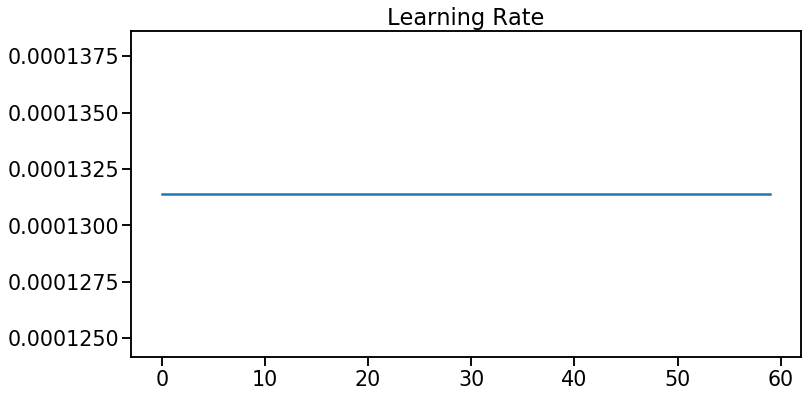

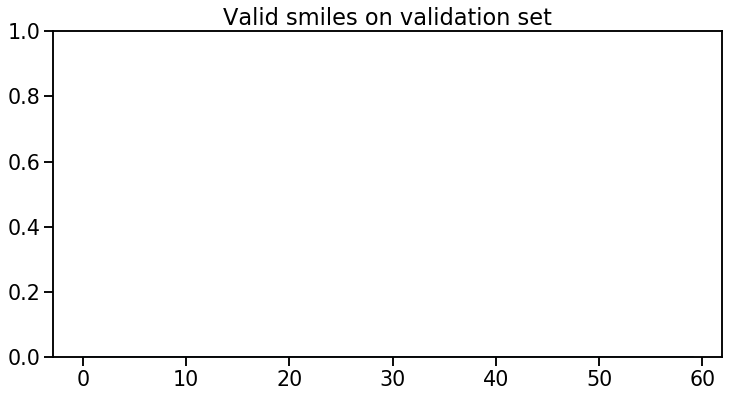

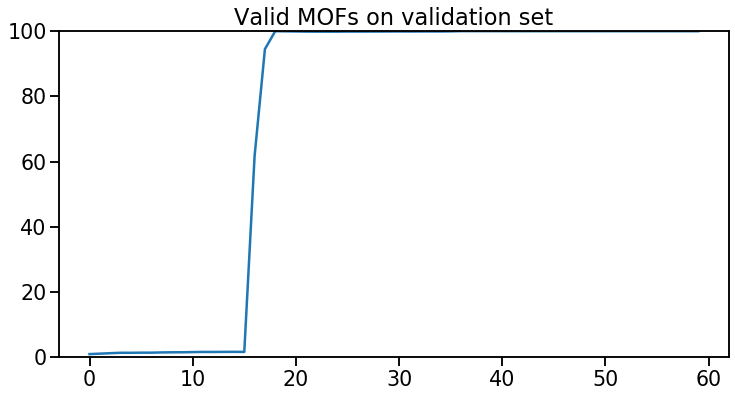

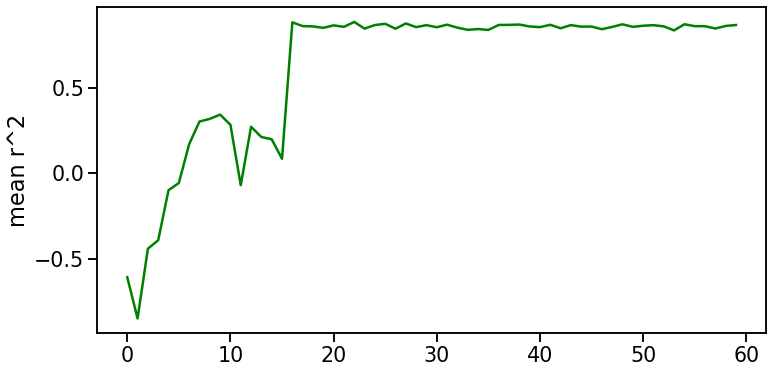

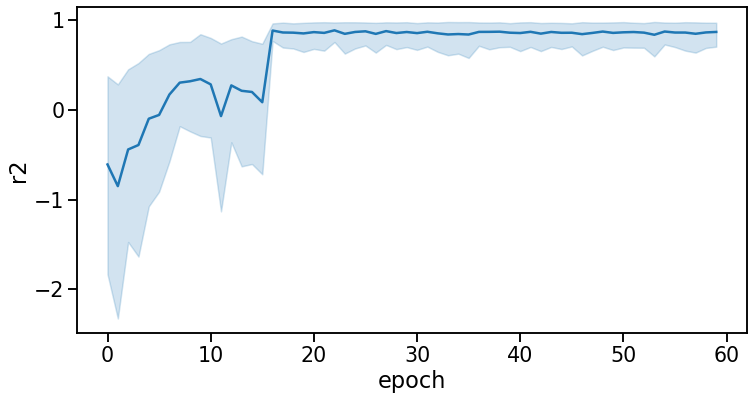

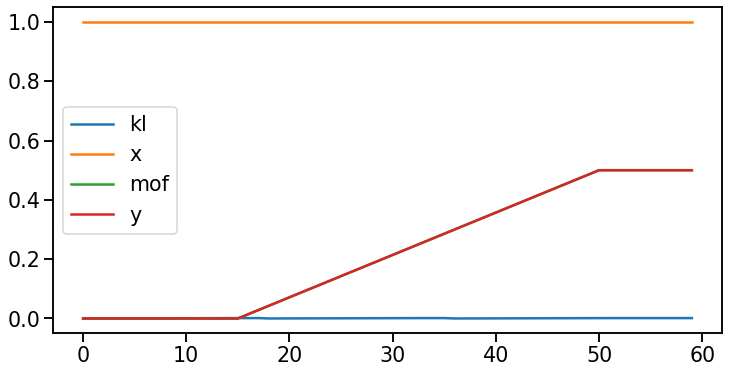

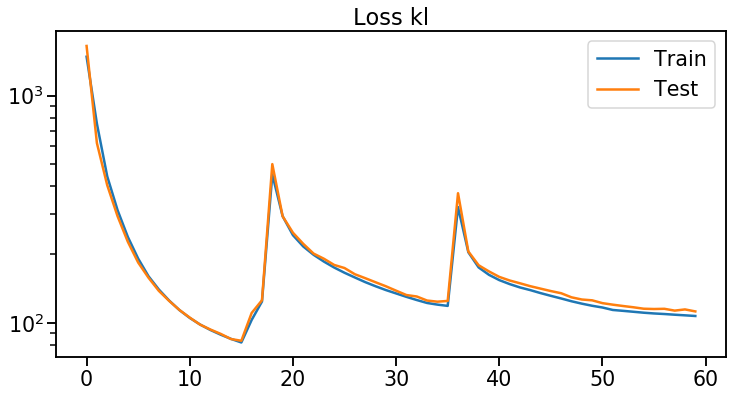

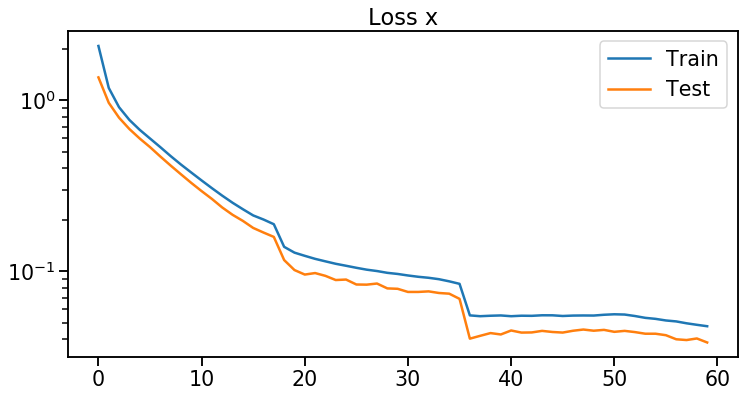

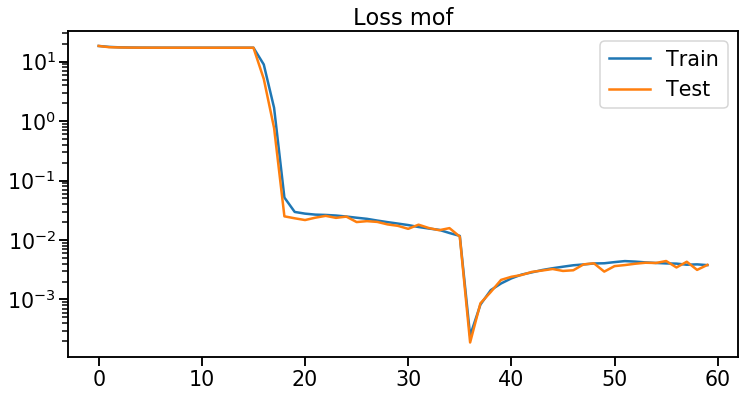

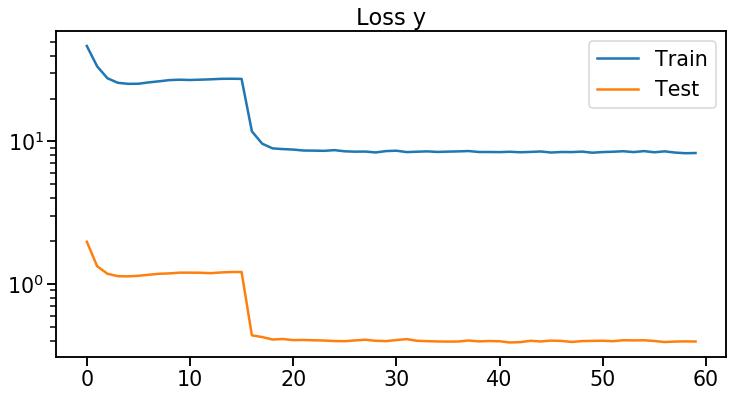

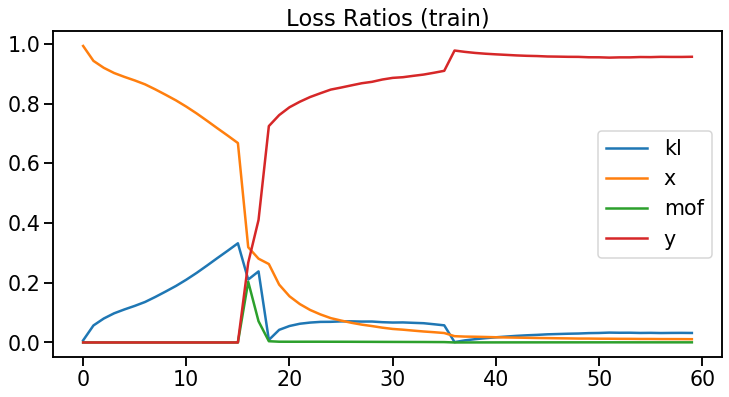

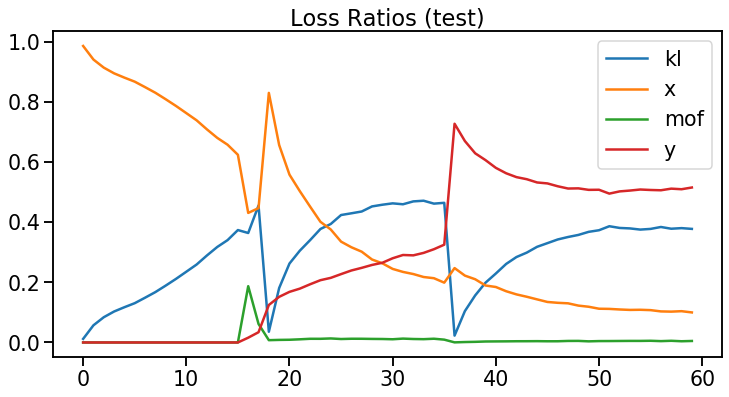

In [12]:
COMPONENTS = training.COMPONENTS
epochs = log_df['epoch'].values

display(log_df.head(2))
plt.plot(epochs, log_df['lr'])
plt.title('Learning Rate')
plt.show()

plt.plot(epochs, log_df['valid_smiles'])
plt.title('Valid smiles on validation set')
plt.ylim([0,1])
plt.show()

plt.plot(epochs, log_df['mof_acc'])
plt.title('Valid MOFs on validation set')
plt.ylim([0,100])
plt.show()

plt.plot(epochs, log_df['mean_r2'],c='g',label='valid')
plt.ylabel('mean r^2')
plt.show()

results=[]
for label in hparams['y_labels']:
    metric = f'{label}-r2'
    results.extend([{'epoch':epoch,'r2':value,"prop":label} for epoch, value in log_df[['epoch',metric]].values ]  )
prop_df = pd.DataFrame(results)
sns.lineplot(x='epoch',y='r2', data=prop_df)
plt.show()

for label in COMPONENTS:
    plt.plot(epochs, log_df[f'λ_{label}'], label =label)
plt.legend()
plt.show()

for label in COMPONENTS:
    plt.plot(epochs, log_df[f'train_{label}'], label='Train')
    plt.plot(epochs, log_df[f'test_{label}'], label='Test')
    plt.title(f'Loss {label}')
    plt.yscale("log")
    plt.legend()
    plt.show()

for prefix in ['train','test']:
    for label in COMPONENTS:
        plt.plot(epochs, log_df[f'{prefix}_{label}_ratio'], label=label) 
    plt.title(f'Loss Ratios ({prefix})')
    plt.legend()
    plt.show()

In [ ]:
test_mof = model.df_to_tuples(df.loc[test_index], smiles_column)
prop_test = model.df_to_tuples(prop_df.loc[prop_test_index], smiles_column)
len(test_mof), len(prop_test)


In [14]:
print(header_str('R^2 scores and MAEs'))
src_data = prop_test
n = len(src_data)
batch_size=64
n_loops = int(np.ceil(n / batch_size))
y_true = []
y_pred = []
with torch.no_grad():
    for chunk in  tqdm(utils.chunks(src_data,batch_size),total=n_loops, desc='Generating predictions'):
        x_tensor = model.tuples_to_tensors(chunk)['x']
        mof_tensor = model.tuples_to_tensors(chunk)['mof']
        y_tensor = model.tuples_to_tensors(chunk)['y']
        y_mask = model.tuples_to_tensors(chunk)['y_mask']
        losses,outs = model.forward(x_tensor,mof_tensor,y_tensor,y_mask)
        y_true.extend(model.vocab_y.inverse_transform(y_tensor))
        y_pred.extend(model.z_to_outputs(len(chunk))['y'])
y_pred = np.stack(y_pred)
y_true = np.stack(y_true)
for index,col in enumerate(hparams.y_labels):
    r2 = sklearn.metrics.r2_score(y_true[:,index],y_pred[:,index])
    mae = sklearn.metrics.mean_absolute_error(y_true[:,index],y_pred[:,index])
    print('{:20} -> r^2= {:3f}, MAE= {:.3f}'.format(col,r2,mae))

============================= R^2 scores and MAEs ==============================



lcd                  -> r^2= -0.198355, MAE= 11.445
pld                  -> r^2= -0.173280, MAE= 10.043
density              -> r^2= -0.161436, MAE= 0.227
avf                  -> r^2= -0.115890, MAE= 0.182
avsa                 -> r^2= -0.091899, MAE= 456.313
agsa                 -> r^2= -0.124089, MAE= 1501.844
co2n2_co2_mol_kg     -> r^2= -0.086637, MAE= 0.137
co2n2_n2_mol_kg      -> r^2= -0.083445, MAE= 0.115
co2n2_selectivity    -> r^2= -0.049508, MAE= 3.374
co2n2_heat_avg       -> r^2= -0.056369, MAE= 4.071
co2n2_heat_co2       -> r^2= -0.075308, MAE= 4.446
co2n2_heat_n2        -> r^2= -0.060025, MAE= 2.167
co2n2_heat_molfrac   -> r^2= -0.053643, MAE= 4.141
co2ch4_co2_mol_kg    -> r^2= -0.063871, MAE= 0.280
co2ch4_ch4_mol_kg    -> r^2= -0.084100, MAE= 0.678
co2ch4_selectivity   -> r^2= -0.073219, MAE= 0.875
co2ch4_heat_avg      -> r^2= -0.041506, MAE= 3.203
co2ch4_heat_co2      -> r^2= -0.061307, MAE= 3.951
co2ch4_heat_ch4      -> r^2= -0.059436, MAE= 2.731
co2ch4_heat_molfrac  ->

## Prior check

In [141]:
print(header_str('prior'))
samples = []
n = 1024
batch_size=64
n_loops = int(np.ceil(n/batch_size))
for chunk in  tqdm(vaemof.utils.chunks(list(range(n)),batch_size),total=n_loops, desc='Generating samples'):
    n_batch = min(len(chunk), batch_size)
    z = model.sample_z_prior(n_batch)
    smiles_list = model.z_to_outputs(n_batch)['x']
    mof_list = model.z_to_outputs(n_batch)['mof']
    samples.extend([ [smi]+mof for smi,mof in zip(smiles_list,mof_list)])
    
gen_df = pd.DataFrame(samples,columns=[smiles_column]+mof_columns)
gen_df['valid'] = gen_df[smiles_column].apply(vaemof.vocabs.valid_smiles)
print('valid smiles: {} out of {} ({}%)'.format(gen_df['valid'].sum(),n,gen_df['valid'].sum()/n*100.0))

==================================== prior =====================================



valid smiles: 300 out of 1024 (29.296875%)


## Posterior check

In [53]:
print(header_str('Posterior check'))

tries=2
sub_sample =1000
src_data = train_data
src_data = random.sample(src_data,min(len(src_data),sub_sample))
valid_smiles=[]
recon_smiles=[]
n = len(src_data)
results=[]
mof_results=[]
with torch.no_grad():
    for t in tqdm(src_data[1:3]):
        batch = [t]*tries
        true_smiles = vaemof.vocabs.isosmiles(vocab.ids_to_string(t[0]))
        true_mof = vocab_mof.ids_to_mof(t[1])
        x_tensor = model.tuples_to_tensors(batch)['x']
        mof_tensor = model.tuples_to_tensors(batch)['mof']
        y_tensor = model.tuples_to_tensors(batch)['y']
        y_mask = model.tuples_to_tensors(batch)['y_mask']
        losses,outs = model.forward(x_tensor,mof_tensor,y_tensor,y_mask)
        smiles_list = model.z_to_outputs(tries)['x']
        mof_list = model.z_to_outputs(tries)['mof']
        acc_mof = any([ all(i==true_mof) for i in np.array(mof_list)])
        valid_smiles = [si for si in set(smiles_list) if vaemof.vocabs.valid_smiles(si)]
        valid_smiles = [vaemof.vocabs.isosmiles(si) for si in valid_smiles]
        same_smiles = [si for si in valid_smiles if si==true_smiles]
        results.append([true_smiles, smiles_list[0], len(same_smiles)>0,len(valid_smiles)>0])
        mof_results.append(acc_mof)
        
post_df = pd.DataFrame(results,columns=['smiles','recon_smiles','same','valid'])
print('valid: {} out of {} ({:.2f}%)'.format(post_df['valid'].sum(),n,post_df['valid'].sum()/n*100.0))
print('same : {} out of {} ({:.2f}%)'.format(post_df['same'].sum(),n,post_df['same'].sum()/n*100.0))
display(post_df.head())
print('MOF recon acc: {}'.format(float(sum(mof_results))/float(len(mof_results))))

=============================== Posterior check ================================


['sym_3_mc_0', 'sym_3_vae_45', 'srsb', 556]
[['sym_5_mc_2', 'sym_3_vae_762', 'ctn', 306], ['sym_5_mc_2', 'sym_5_vae_795', 'ssb', 419]]
False
['sym_4_mc_1', 'sym_3_vae_210', 'bor', 24]
[['sym_5_mc_2', 'sym_3_on_2', 'pto', 288], ['sym_5_mc_2', 'sym_5_vae_795', 'ssa', 51]]
False

valid: 2 out of 1000 (0.20%)
same : 0 out of 1000 (0.00%)


smiles                    recon_smiles   same  \
0            CSC1=C([Lr])NN(SC)C1[Lr]                                  False   
1  Oc1cc([Lr])ccc1-c1nc([Lr])nc(O)c1O  C#CC(CO)(OC)c1cccc(CC=O)c1[Lr]  False   

   valid  
0   True  
1   True

MOF recon acc: 0.0


In [149]:
sub_sample = 10000
src_data = train_data
src_data = random.sample(src_data,min(len(src_data),sub_sample))
n = len(src_data)
batch_size=64
n_loops = int(np.ceil(n/batch_size))
z=[]
mof=[]
mof_ids=[]
y=[]
with torch.no_grad():
    for chunk in tqdm(utils.chunks(src_data,batch_size),total=n_loops, desc='Generating predictions'):
        mof.extend([vocab_mof.ids_to_mof(t[1]) for t in chunk])
        x_tensor = model.tuples_to_tensors(chunk)['x']
        mof_tensor = model.tuples_to_tensors(chunk)['mof']
        y_tensor = model.tuples_to_tensors(chunk)['y']
        y_mask = model.tuples_to_tensors(chunk)['y_mask']
        y.extend(model.vocab_y.inverse_transform(y_tensor))
        losses,outs = model.forward(x_tensor,mof_tensor,y_tensor,y_mask)
        z_tensor = model.inputs_to_z(x_tensor,mof_tensor)
        z.extend(z_tensor.cpu().numpy())
        
z = np.stack(z)
z_pca = PCA(2).fit_transform(z)
z_mof_df = pd.DataFrame(mof,columns=mof_columns)
z_mof_df['x']=z_pca[:,0]
z_mof_df['y']=z_pca[:,1]
print(z.shape)
z_mof_df.head()


(10000, 256)


metal_node     organic_core topology  id2mof         x         y
0  sym_8_mc_9  sym_5_vae_BR911      csq      90  1.245603  2.911056
1  sym_5_mc_2     sym_3_vae_45      tbo     615  0.332393  2.866596
2  sym_3_mc_0   sym_4_vae_2723      ctn      96  3.889220  2.246685
3  sym_3_mc_0   sym_5_vae_1038      pto     273 -1.916635  0.069147
4  sym_8_mc_9    sym_5_vae_218      scu     482 -3.644753  3.108333

================================== metal_node ==================================


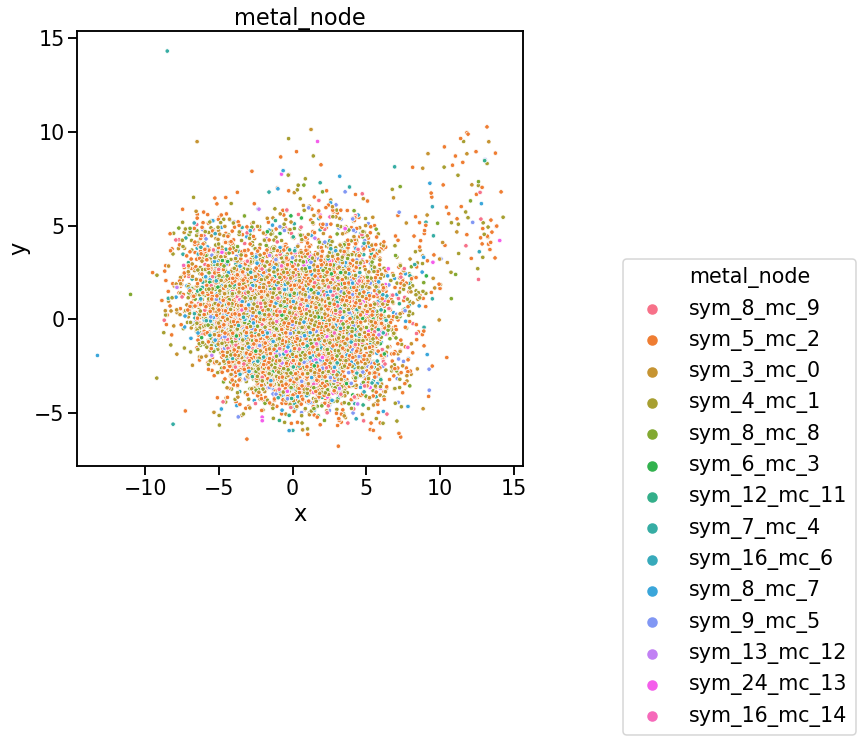

================================= organic_core =================================


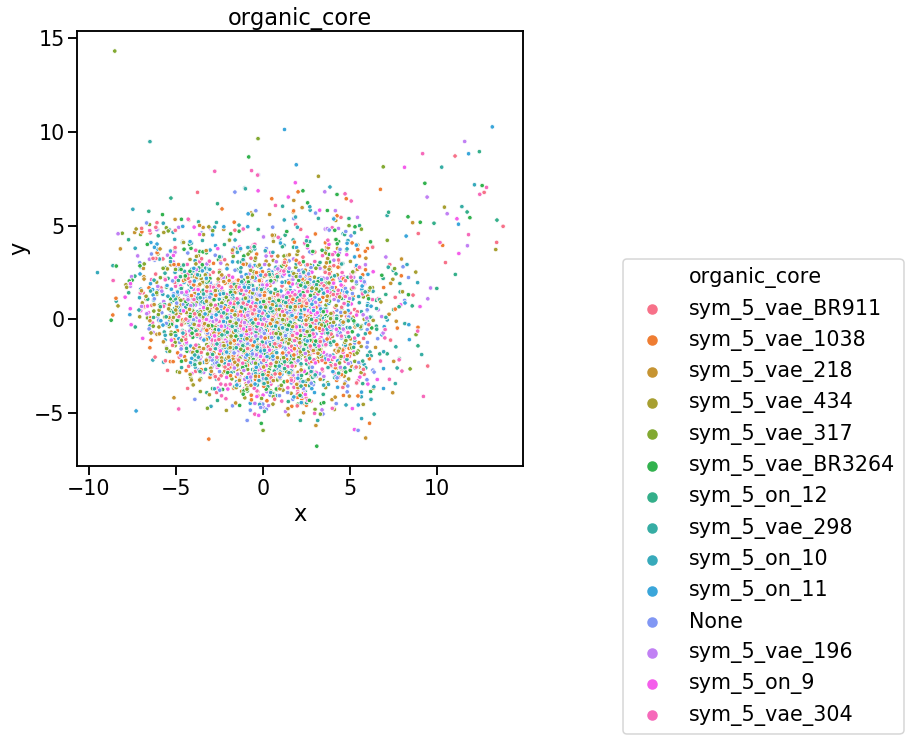

=================================== topology ===================================


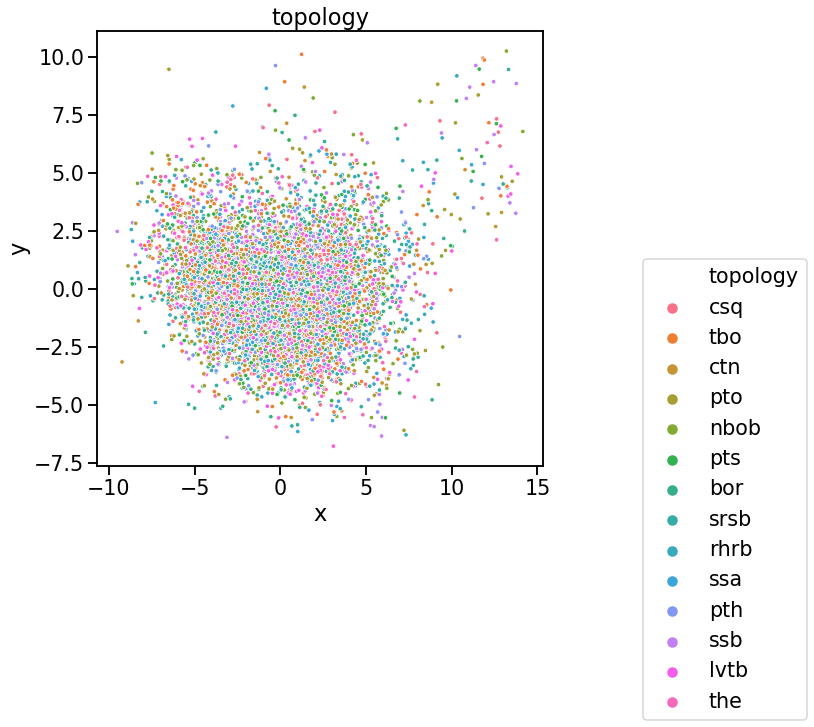

==================================== id2mof ====================================


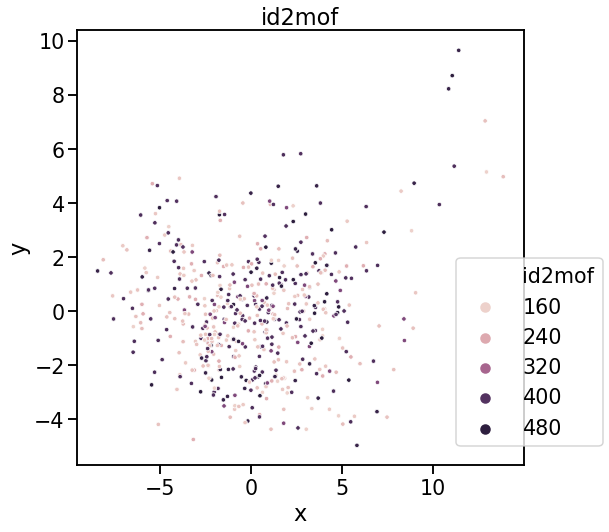

In [150]:
top_k=14
for index,col in enumerate(mof_columns):
    print(header_str(col))
    plt.figure(figsize=(8,8))
    top_cat = z_mof_df[col].value_counts(sort=True).iloc[:top_k].index.tolist()
    sns.scatterplot(x='x',y='y',hue=col,s=20,data=z_mof_df[z_mof_df[col].isin(top_cat)])
    plt.legend(bbox_to_anchor=(1.2, .5))
    plt.title(col)
    plt.show()

In [70]:
sub_sample = 10000
src_data = prop_test
src_data = random.sample(src_data,min(len(src_data),sub_sample))
n = len(src_data)
batch_size=64
n_loops = int(np.ceil(n/batch_size))
z=[]
mof=[]
mof_ids=[]
y=[]
with torch.no_grad():
    for chunk in tqdm(utils.chunks(src_data,batch_size),total=n_loops, desc='Generating predictions'):
        mof.extend([vocab_mof.ids_to_mof(t[1]) for t in chunk])
        x_tensor = model.tuples_to_tensors(chunk)['x']
        mof_tensor = model.tuples_to_tensors(chunk)['mof']
        y_tensor = model.tuples_to_tensors(chunk)['y']
        y_mask = model.tuples_to_tensors(chunk)['y_mask']
        y.extend(model.vocab_y.inverse_transform(y_tensor))
        losses,outs = model.forward(x_tensor,mof_tensor,y_tensor,y_mask)
        z_tensor = model.inputs_to_z(x_tensor,mof_tensor)
        z.extend(z_tensor.cpu().numpy())
        
z = np.stack(z)
print(z)
z_pca = PCA(2).fit_transform(z)
z_y_df = pd.DataFrame(y,columns=hparams.y_labels)
z_y_df['x']=z_pca[:,0]
z_y_df['y']=z_pca[:,1]
print(z.shape)
z_y_df.head()


[[-0.10550711  1.3361443  -0.06946807 ...  0.51320875 -1.5273743
   0.22415654]
 [-0.7777518   0.5767835  -0.2209846  ...  0.04854089 -0.8360679
  -0.49201688]
 [-0.08479753  0.354012   -0.31190965 ... -0.18501118 -2.1731753
  -0.28872234]
 ...
 [ 0.08474945 -0.59479004  0.02904191 ...  0.47297072  0.24817437
   0.18946639]
 [-0.30648682 -0.6703545   0.09152217 ... -0.16840565 -1.1199769
   0.2926894 ]
 [ 0.03818297  0.35889155 -0.09153701 ...  0.30076212  0.05042873
   0.49033892]]
(4107, 256)


lcd        pld   density      avf         avsa         agsa  \
0  29.691050  24.589029  0.106014  0.82620   843.862000  7959.890137   
1  65.213882  64.389442  0.171699  0.77845   745.233948  4340.350098   
2  21.641960  18.777281  0.258876  0.63451  1556.219971  6011.430176   
3  31.674801  20.986469  0.187476  0.72634  1134.650024  6052.250000   
4  24.906639  19.626711  0.167494  0.73152  1100.900024  6572.770020   

   co2n2_co2_mol_kg  co2n2_n2_mol_kg  co2n2_selectivity  co2n2_heat_avg  ...  \
0          0.328219         0.538363           3.454748        -9.06447  ...   
1          0.355047         0.343062           5.864634       -13.10773  ...   
2          0.187349         0.282177           3.762329       -10.92581  ...   
3          0.620756         0.399488           8.805311       -15.45323  ...   
4          0.237246         0.366438           3.668822       -11.03792  ...   

   co2ch4_co2_mol_kg  co2ch4_ch4_mol_kg  co2ch4_selectivity  co2ch4_heat_avg  \
0           0.980733           4.163787            2.119848         -8.85875   
1           1.091421           3.467767            2.832597        -11.74349   
2           0.699906           3.097026            2.033936        -11.01631   
3           1.342828           3.480537            3.472295        -12.05334   
4           0.672083           3.192131            1.894894        -10.07088   

   co2ch4_heat_co2  co2ch4_heat_ch4  co2ch4_heat_molfrac   scscore         x  \
0       -14.228160         -7.66012             -8.91202  4.309125 -1.464390   
1       -18.674931        -10.02599            -12.09691  3.935780  1.356654   
2       -15.365170        -10.10086            -11.07011  3.840324  1.172857   
3       -18.556450         -9.84825            -12.26881  3.910479  2.118413   
4       -14.279640         -9.22599            -10.10570  3.546803 -0.905370   

          y  
0  6.474171  
1  7.347672  
2  1.554471  
3  4.902551  
4  0.302888  

[5 rows x 23 columns]

===================================== lcd ======================================


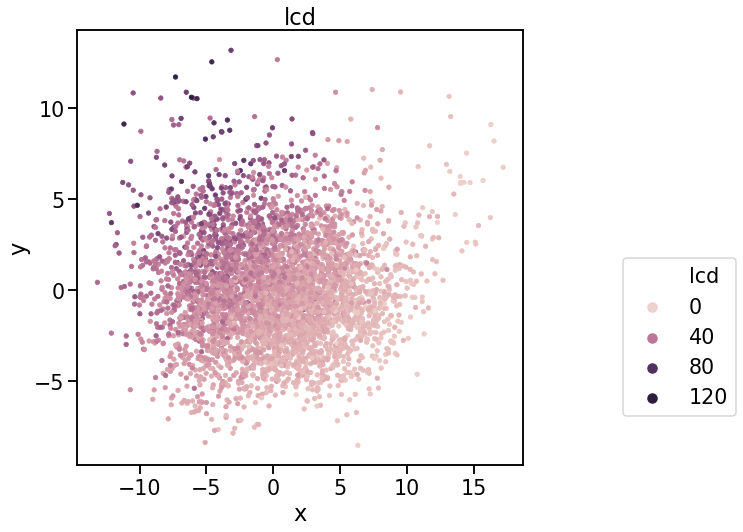

===================================== pld ======================================


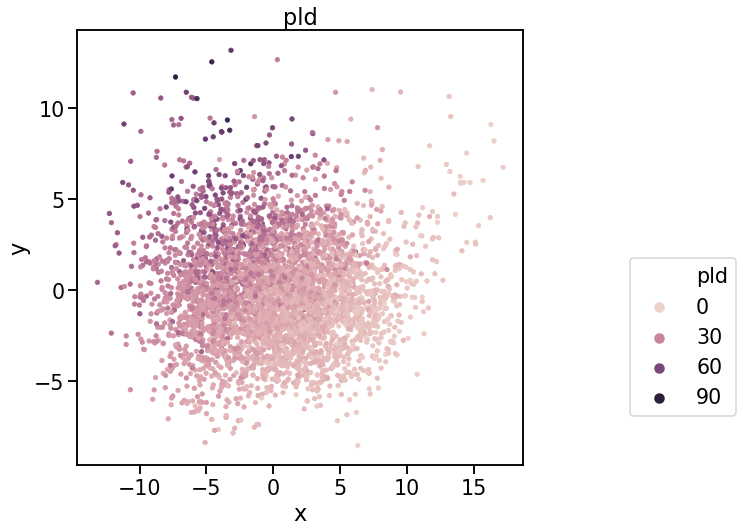

=================================== density ====================================


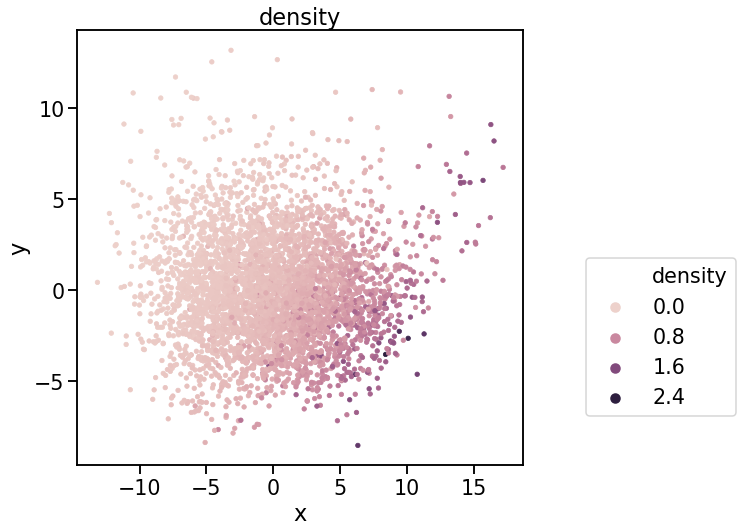

===================================== avf ======================================


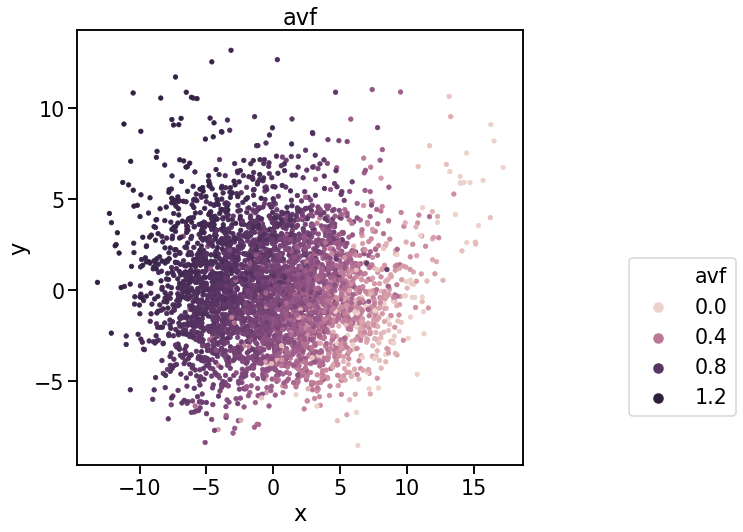

===================================== avsa =====================================


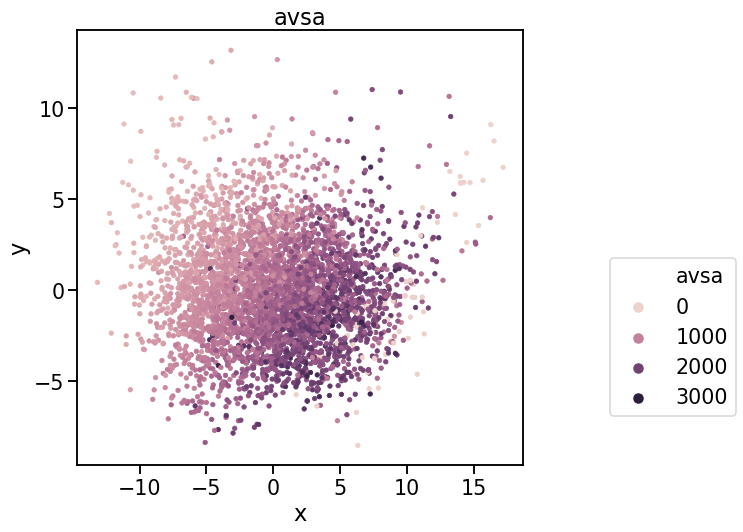

===================================== agsa =====================================


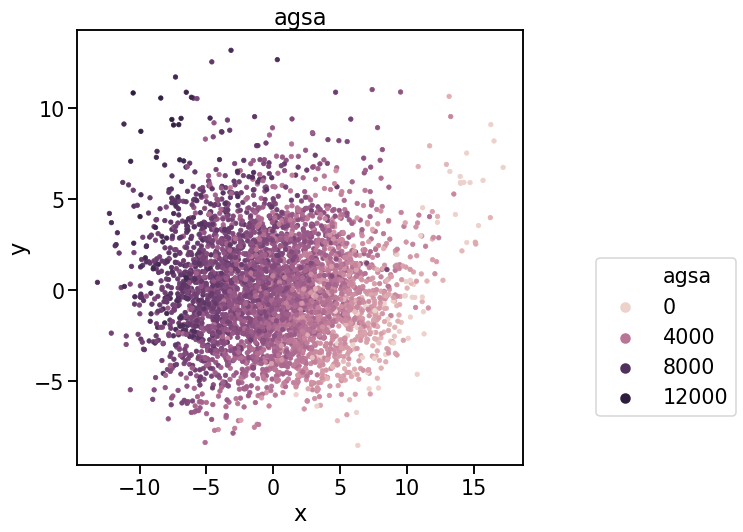

=============================== co2n2_co2_mol_kg ===============================


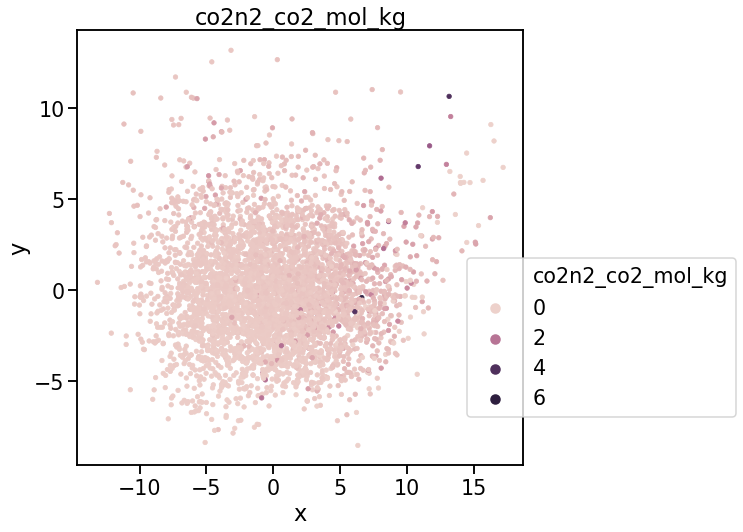

=============================== co2n2_n2_mol_kg ================================


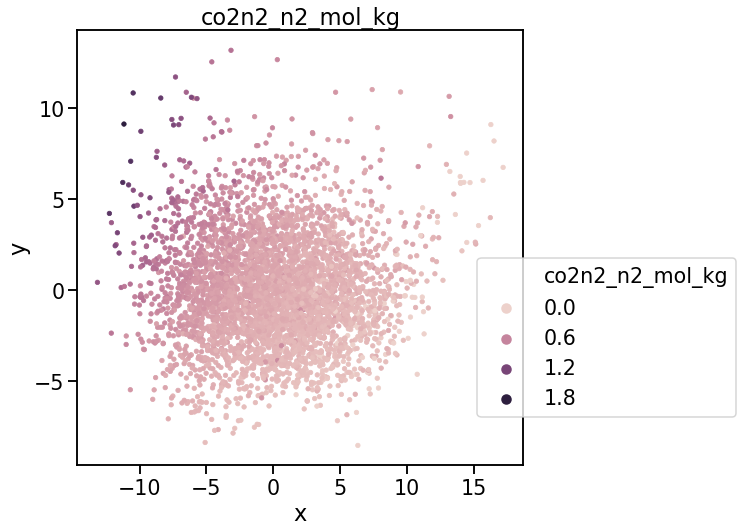

============================== co2n2_selectivity ===============================


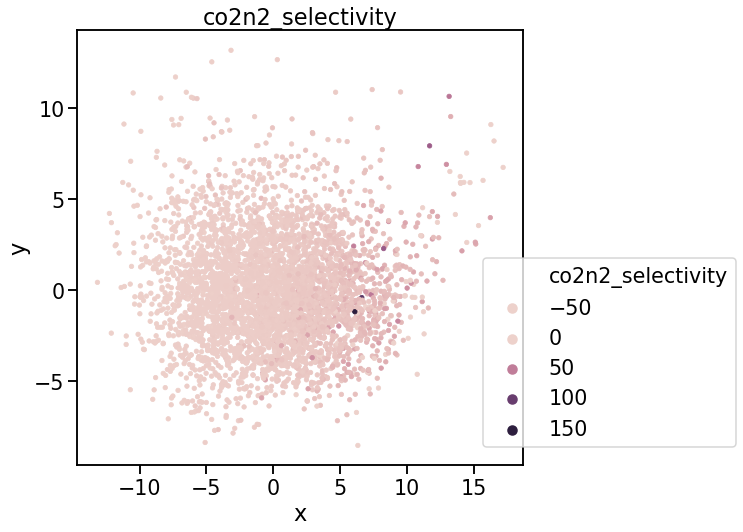

================================ co2n2_heat_avg ================================


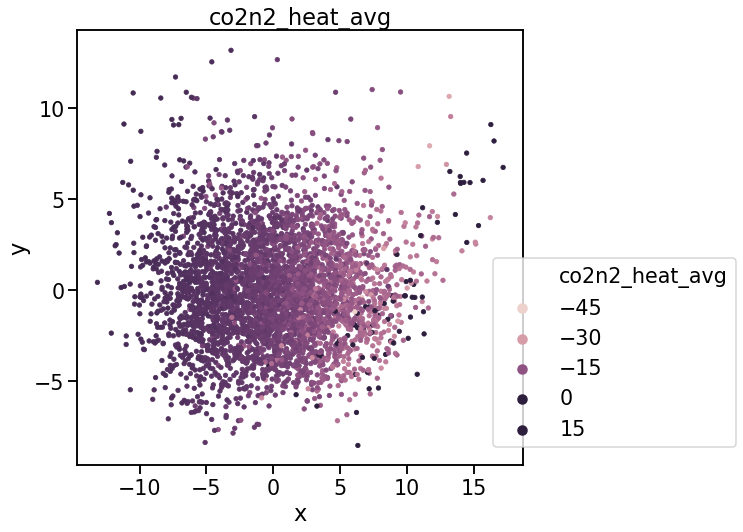

================================ co2n2_heat_co2 ================================


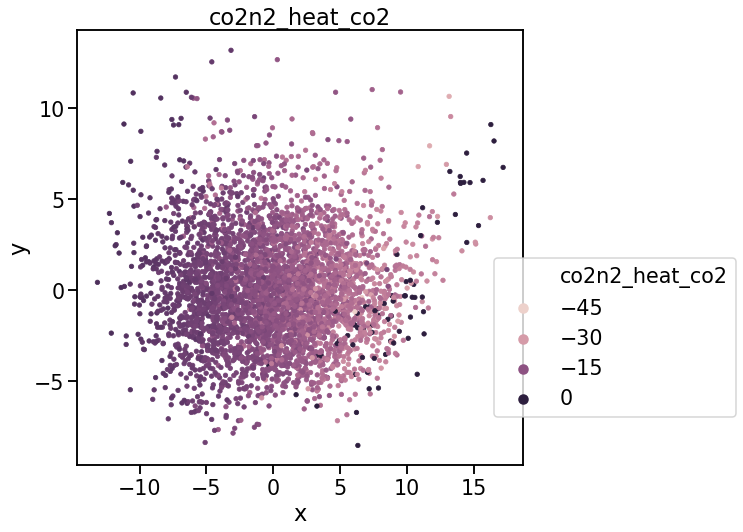

================================ co2n2_heat_n2 =================================


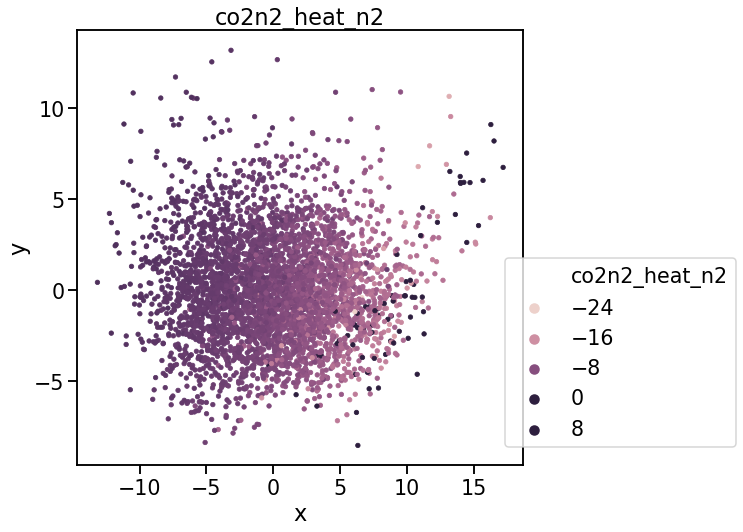

============================== co2n2_heat_molfrac ==============================


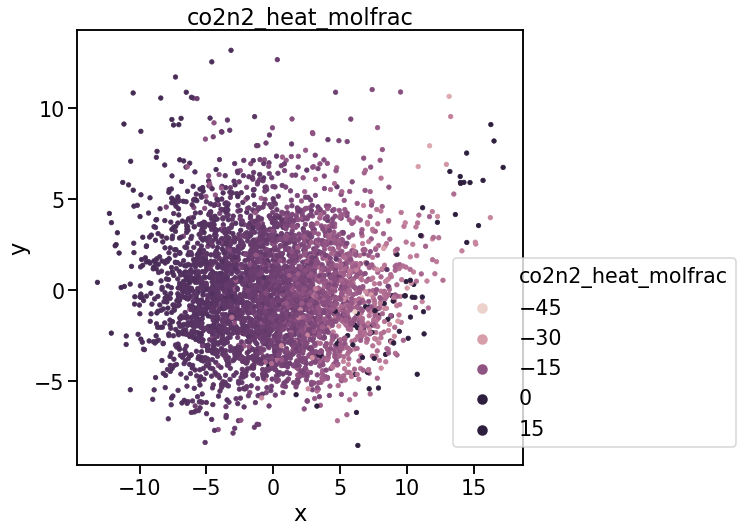

============================== co2ch4_co2_mol_kg ===============================


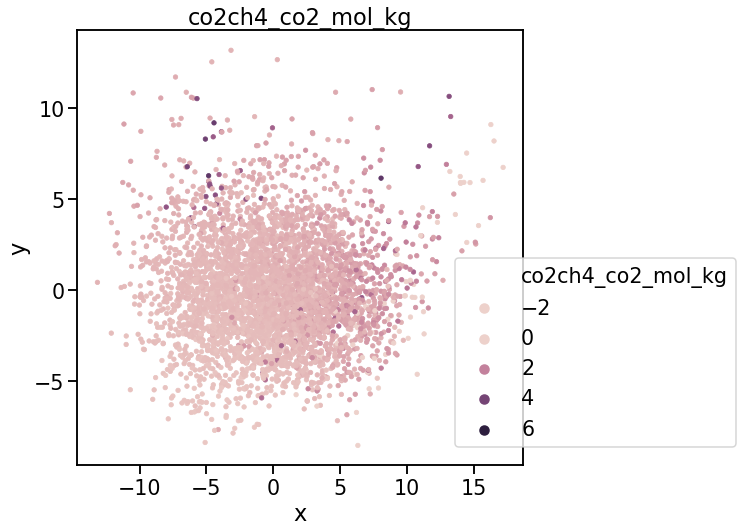

============================== co2ch4_ch4_mol_kg ===============================


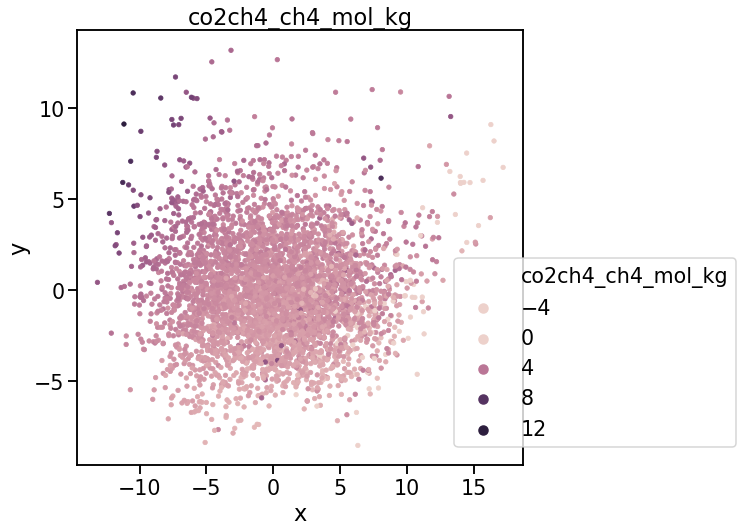

============================== co2ch4_selectivity ==============================


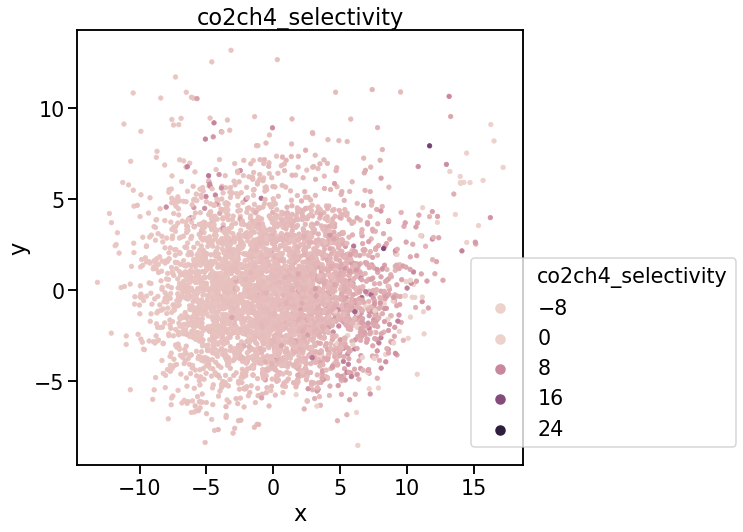

=============================== co2ch4_heat_avg ================================


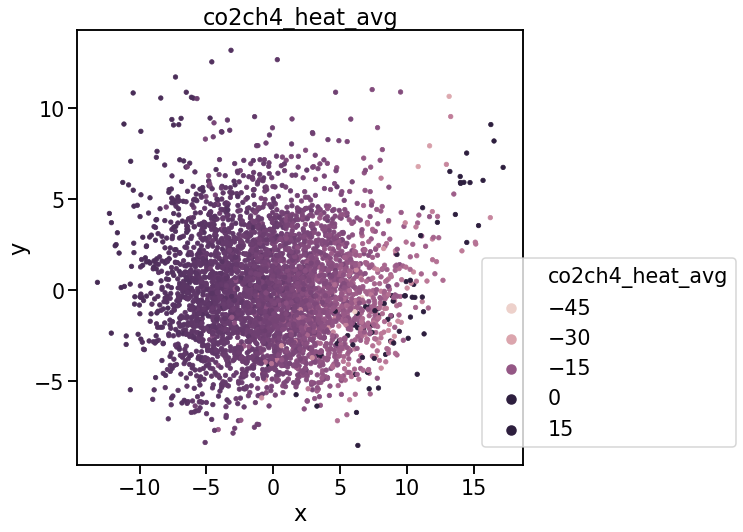

=============================== co2ch4_heat_co2 ================================


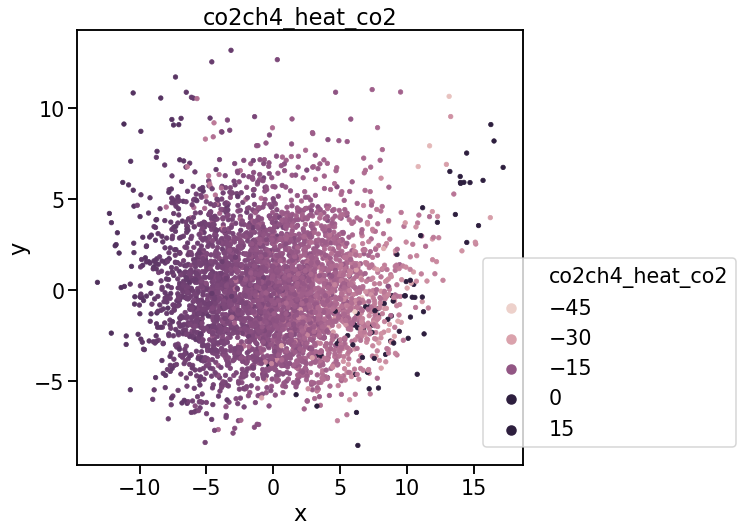

=============================== co2ch4_heat_ch4 ================================


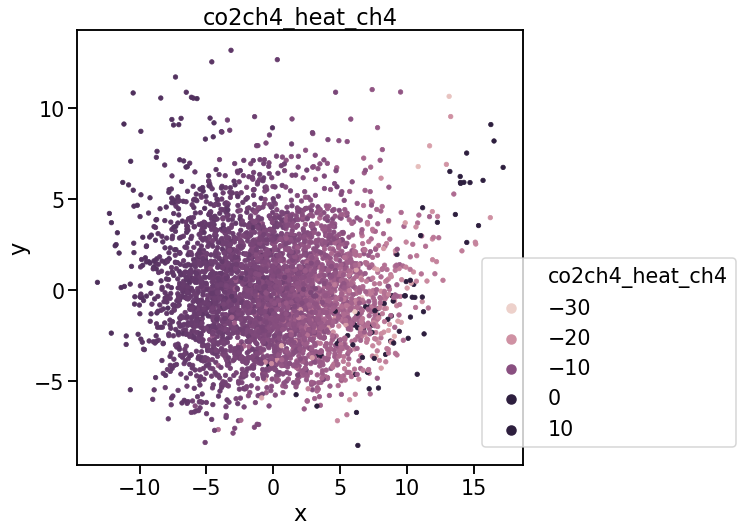

============================= co2ch4_heat_molfrac ==============================


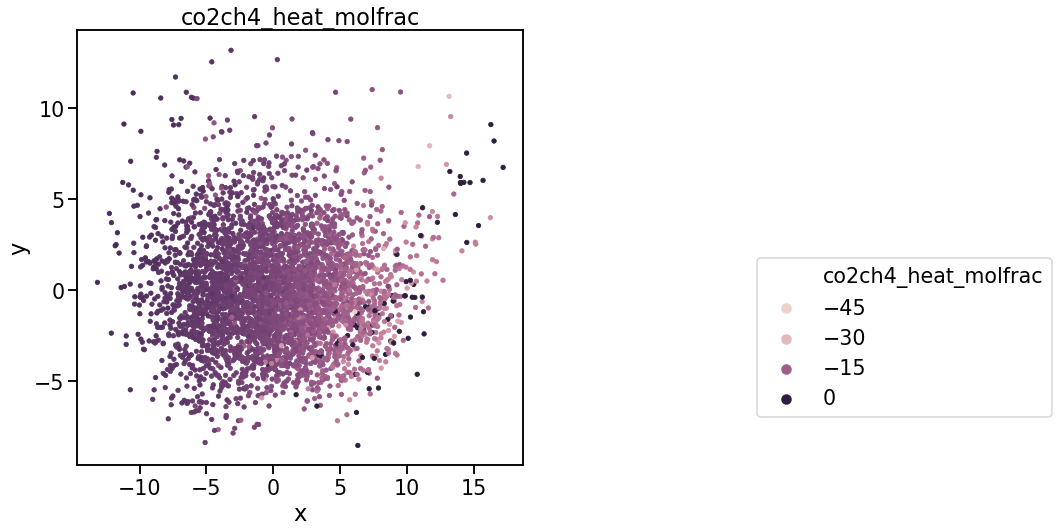

=================================== scscore ====================================


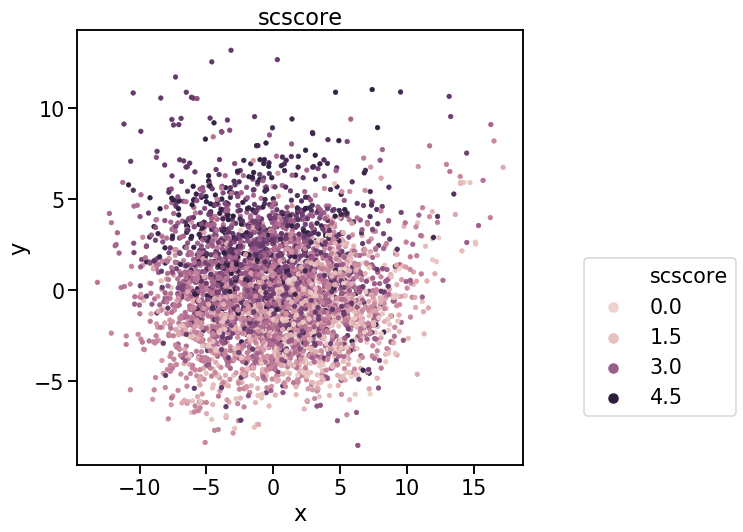

In [139]:
top_k=200
for index,col in enumerate(hparams.y_labels):
    print(header_str(col))
    plt.figure(figsize=(8,8))
    sns.scatterplot(x='x',y='y',hue=col,s=20,data=z_y_df,edgecolor=None)
    #plt.hexbin(z_df['x'], z_df['y'], C=z_df[col], cmap='viridis')
    plt.legend(bbox_to_anchor=(1.5, .5))
    plt.savefig('images/%s.png'%(col),dpi=300)
    plt.title(col)
    plt.show()

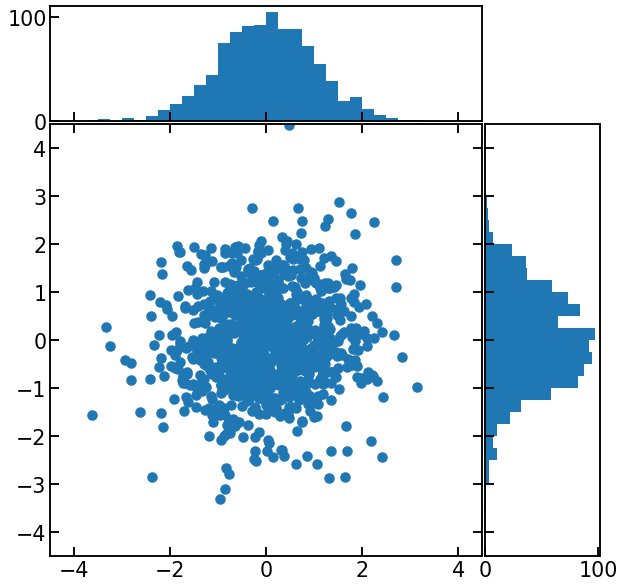

In [120]:
# the random data
x = np.random.randn(1000)
y = np.random.randn(1000)

# definitions for the axes
left, width = 0.1, 0.75
bottom, height = 0.1, 0.75
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, y)

# now determine nice limits by hand:
binwidth = 0.25
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim((-lim, lim))
ax_scatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()